In [ ]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Reason for absence: integer (nullable = true)
 |-- Month of absence: integer (nullable = true)
 |-- Day of the week: integer (nullable = true)
 |-- Seasons: integer (nullable = true)
 |-- Transportation expense: integer (nullable = true)
 |-- Distance from Residence to Work: integer (nullable = true)
 |-- Service time: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Work load Average/day : double (nullable = true)
 |-- Hit target: integer (nullable = true)
 |-- Disciplinary failure: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- Son: integer (nullable = true)
 |-- Social drinker: integer (nullable = true)
 |-- Social smoker: integer (nullable = true)
 |-- Pet: integer (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Body mass index: integer (nullable = true)
 |-- Absenteeism time in hours: integer (nullable = true)



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler

# Initialize Spark Session
spark = SparkSession.builder.appName("AbsenteeismPreprocessing").getOrCreate()

# Load the dataset
data_path = "/content/Absenteeism_at_work.csv"  # Replace with your file path
df = spark.read.csv(data_path, header=True, inferSchema=True,sep=";")


In [ ]:
import numpy as np

In [ ]:
# Check for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Handle missing values (Example: Replace missing numerical values with mean)
numerical_cols = [ 'Distance from Residence to Work',
                  'Service time', 'Age', 'Weight', 'Height', 'Body mass index',
                  'Absenteeism time in hours']

for col_name in numerical_cols:
    mean_value = df.select(mean(col(col_name))).collect()[0][0]
    df = df.na.fill({col_name: mean_value})

# For categorical columns, fill with the most frequent value
categorical_cols = ['Reason for absence', 'Education', 'Social drinker',
                    'Social smoker', 'Seasons', 'Day of the week']
for col_name in categorical_cols:
    mode_value = df.groupBy(col_name).count().orderBy("count", ascending=False).first()[0]
    df = df.na.fill({col_name: mode_value})


+---+------------------+----------------+---------------+-------+----------------------+-------------------------------+------------+---+----------------------+----------+--------------------+---------+---+--------------+-------------+---+------+------+---------------+-------------------------+
| ID|Reason for absence|Month of absence|Day of the week|Seasons|Transportation expense|Distance from Residence to Work|Service time|Age|Work load Average/day |Hit target|Disciplinary failure|Education|Son|Social drinker|Social smoker|Pet|Weight|Height|Body mass index|Absenteeism time in hours|
+---+------------------+----------------+---------------+-------+----------------------+-------------------------------+------------+---+----------------------+----------+--------------------+---------+---+--------------+-------------+---+------+------+---------------+-------------------------+
|  0|                 0|               0|              0|      0|                     0|                        

In [ ]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, when, isnan, count

def handle_outliers_iqr(df: DataFrame, numerical_columns: list, handle_method="cap", lower_threshold=1.5, upper_threshold=1.5) -> DataFrame:
    """
    Detects and handles outliers using the IQR method.

    Parameters:
    - df: Spark DataFrame
    - numerical_columns: List of numerical columns to process
    - handle_method: "cap" to cap outliers, "remove" to drop rows with outliers
    - lower_threshold: The factor to calculate the lower bound for outliers (default is 1.5)
    - upper_threshold: The factor to calculate the upper bound for outliers (default is 1.5)

    Returns:
    - Updated DataFrame with outliers handled
    """

    for column in numerical_columns:
        # Calculate Q1, Q3, and IQR
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
        Q1, Q3 = quantiles[0], quantiles[1]
        IQR = Q3 - Q1

        # Define lower and upper bounds using the threshold parameters
        lower_bound = Q1 - lower_threshold * IQR
        upper_bound = Q3 + upper_threshold * IQR

        # Handle outliers
        if handle_method == "cap":
            # Cap outliers to the nearest bound
            df = df.withColumn(
                column,
                when(col(column) < lower_bound, lower_bound)
                .when(col(column) > upper_bound, upper_bound)
                .otherwise(col(column))
            )
        elif handle_method == "remove":
            # Remove rows with outliers
            df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        else:
            raise ValueError("Invalid handle_method. Use 'cap' or 'remove'.")

    # Optionally, you can handle missing values here, for example, dropping rows with missing values
    # df = df.dropna(subset=numerical_columns)

    return df

# Numerical columns in your dataset
numerical_cols = [
    'Transportation expense', 'Distance from Residence to Work', 'Service time',
    'Age', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours'
]

# Handle outliers by capping them
df_cleaned = handle_outliers_iqr(df, numerical_cols, handle_method="cap", lower_threshold=1.5, upper_threshold=1.5)



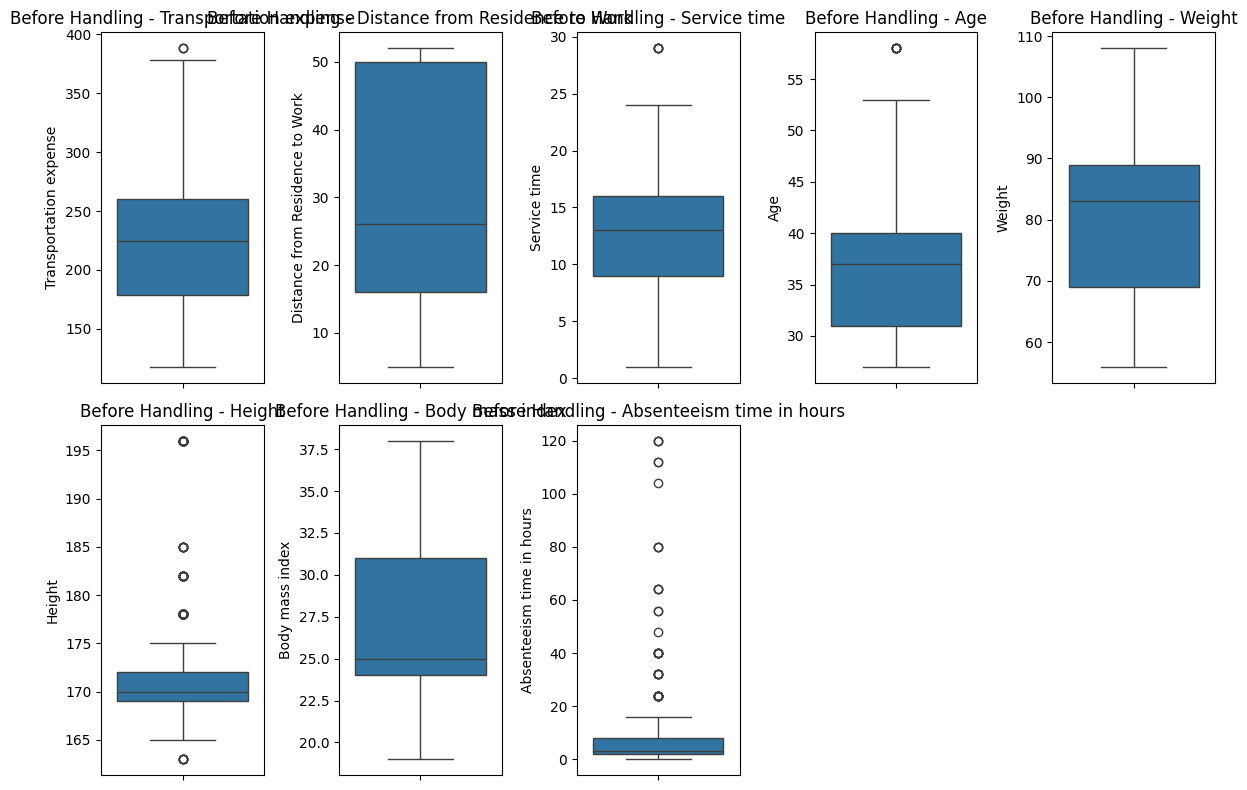

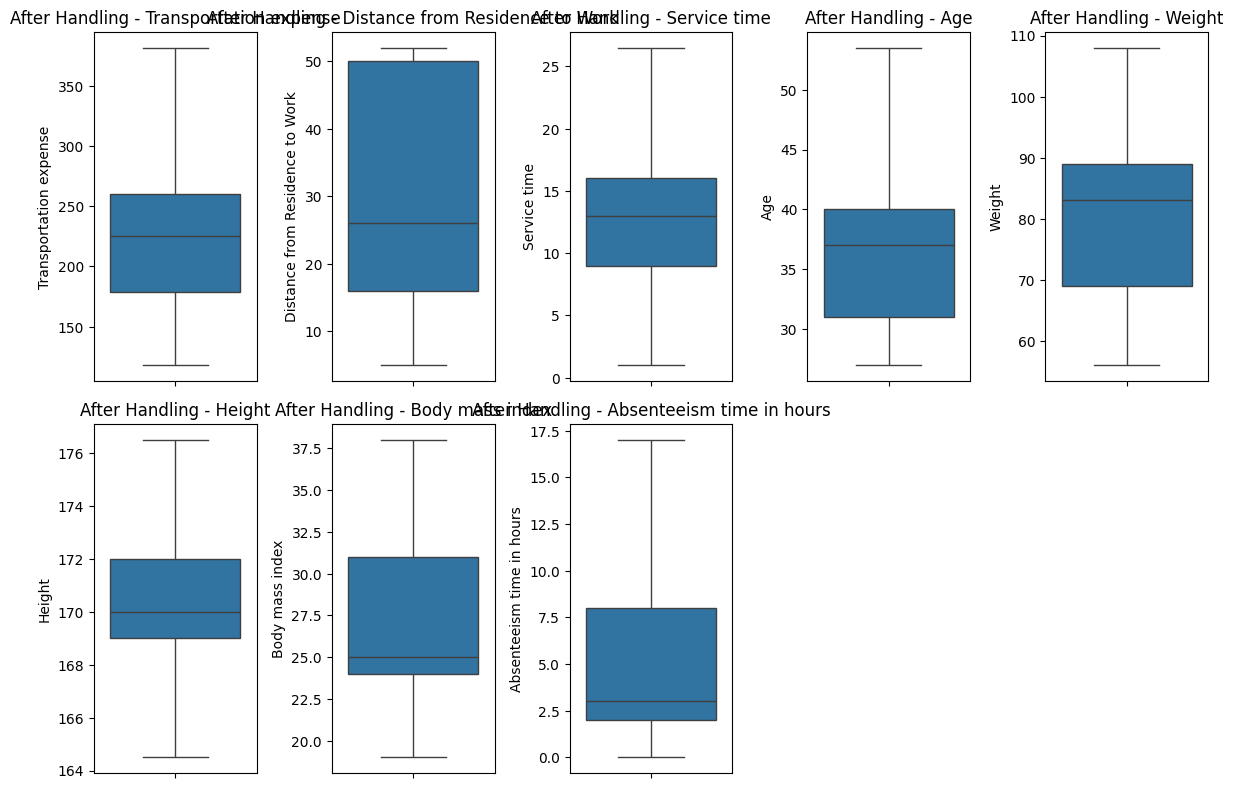

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col

def plot_outliers(df: DataFrame, numerical_columns: list, handle_method="cap"):
    """
    Plots the outliers before and after handling.

    Parameters:
    - df: Spark DataFrame
    - numerical_columns: List of numerical columns to plot
    - handle_method: The outlier handling method (e.g., "cap" or "remove")
    """
    # Collect the original DataFrame (before outlier handling)
    df_original = df.select(numerical_columns).toPandas()

    # Plot original data (before outlier handling)
    plt.figure(figsize=(12, 8))
    for i, column in enumerate(numerical_columns, 1):
        plt.subplot(2, len(numerical_columns)//2 + 1, i)
        sns.boxplot(data=df_original[column])
        plt.title(f'Before Handling - {column}')

    plt.tight_layout()
    plt.show()

    # Apply outlier handling
    df_cleaned = handle_outliers_iqr(df, numerical_columns, handle_method)

    # Collect the cleaned DataFrame (after outlier handling)
    df_cleaned_data = df_cleaned.select(numerical_columns).toPandas()

    # Plot cleaned data (after outlier handling)
    plt.figure(figsize=(12, 8))
    for i, column in enumerate(numerical_columns, 1):
        plt.subplot(2, len(numerical_columns)//2 + 1, i)
        sns.boxplot(data=df_cleaned_data[column])
        plt.title(f'After Handling - {column}')

    plt.tight_layout()
    plt.show()
    return df_cleaned


# Numerical columns in your dataset
numerical_cols = [
    'Transportation expense', 'Distance from Residence to Work', 'Service time',
    'Age', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours'
]

# Call the plot_outliers function to visualize the changes
df_cleaned_data= plot_outliers(df, numerical_cols, handle_method="cap")


In [ ]:
# Define the output path for the cleaned data
output_path = "/content/Fixed_Absenteeism_at_work.csv"  # Replace with your desired file path

# Save the fixed DataFrame as a CSV file
df_cleaned.write.csv(output_path, header=True, mode="overwrite")

print(f"Fixed data saved to: {output_path}")

Fixed data saved to: /content/Fixed_Absenteeism_at_work.csv


In [ ]:
df_cleaned.show(5)

+---+------------------+----------------+---------------+-------+----------------------+-------------------------------+------------+----+----------------------+----------+--------------------+---------+---+--------------+-------------+---+------+------+---------------+-------------------------+
| ID|Reason for absence|Month of absence|Day of the week|Seasons|Transportation expense|Distance from Residence to Work|Service time| Age|Work load Average/day |Hit target|Disciplinary failure|Education|Son|Social drinker|Social smoker|Pet|Weight|Height|Body mass index|Absenteeism time in hours|
+---+------------------+----------------+---------------+-------+----------------------+-------------------------------+------------+----+----------------------+----------+--------------------+---------+---+--------------+-------------+---+------+------+---------------+-------------------------+
| 11|                26|               7|              3|      1|                 289.0|                     

In [ ]:
# List of numerical columns for correlation
numerical_cols = [
    'Transportation expense', 'Distance from Residence to Work', 'Service time',
    'Age', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours'
]

# Compute the correlation between all pairs of numerical columns
correlations = {}
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        col1 = numerical_cols[i]
        col2 = numerical_cols[j]
        correlation_value = df_cleaned.stat.corr(col1, col2)
        correlations[(col1, col2)] = correlation_value

# Show the correlation values
for pair, corr in correlations.items():
    print(f"Correlation between {pair[0]} and {pair[1]}: {corr}")

Correlation between Transportation expense and Distance from Residence to Work: 0.2628247376268293
Correlation between Transportation expense and Service time: -0.3586381537638759
Correlation between Transportation expense and Age: -0.23466274731018247
Correlation between Transportation expense and Weight: -0.2075418554677059
Correlation between Transportation expense and Height: -0.1537310467673748
Correlation between Transportation expense and Body mass index: -0.13640166653859417
Correlation between Transportation expense and Absenteeism time in hours: 0.14122490489552084
Correlation between Distance from Residence to Work and Service time: 0.12868740532376613
Correlation between Distance from Residence to Work and Age: -0.14116705789320408
Correlation between Distance from Residence to Work and Weight: -0.047859093516036066
Correlation between Distance from Residence to Work and Height: -0.3332098571283448
Correlation between Distance from Residence to Work and Body mass index: 0.1

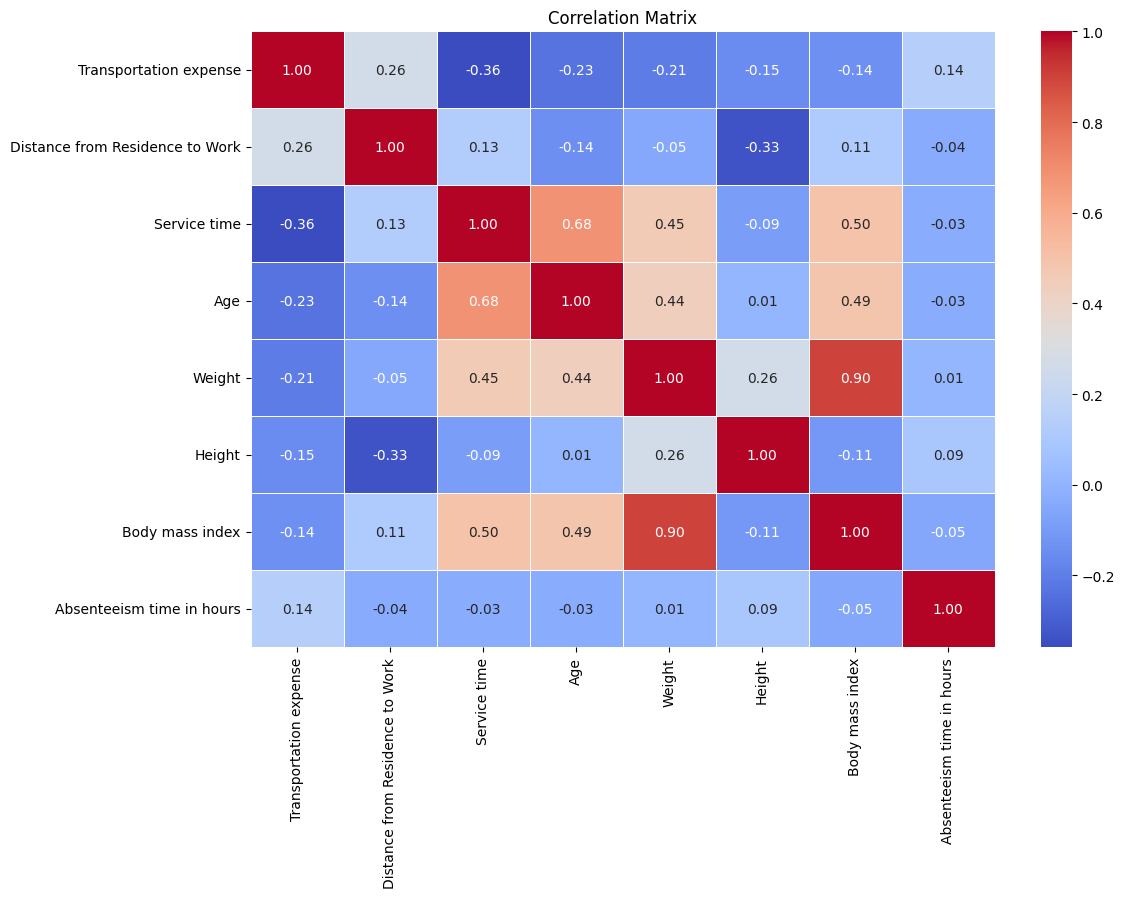

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect the correlation data into a Pandas DataFrame
correlation_matrix = []
for col1 in numerical_cols:
    row = []
    for col2 in numerical_cols:
        correlation_value = df_cleaned.stat.corr(col1, col2)
        row.append(correlation_value)
    correlation_matrix.append(row)

# Convert to a Pandas DataFrame
corr_df = pd.DataFrame(correlation_matrix, columns=numerical_cols, index=numerical_cols)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
numerical_cols = [
    'Transportation expense', 'Distance from Residence to Work',
    'Age', 'Weight', 'Height'
]

categorical_cols = ['Reason for absence', 'Education', 'Social drinker',
                    'Social smoker', 'Seasons', 'Day of the week']

In [ ]:
df_cleaned_data.show(5)

+---+------------------+----------------+---------------+-------+----------------------+-------------------------------+------------+----+----------------------+----------+--------------------+---------+---+--------------+-------------+---+------+------+---------------+-------------------------+
| ID|Reason for absence|Month of absence|Day of the week|Seasons|Transportation expense|Distance from Residence to Work|Service time| Age|Work load Average/day |Hit target|Disciplinary failure|Education|Son|Social drinker|Social smoker|Pet|Weight|Height|Body mass index|Absenteeism time in hours|
+---+------------------+----------------+---------------+-------+----------------------+-------------------------------+------------+----+----------------------+----------+--------------------+---------+---+--------------+-------------+---+------+------+---------------+-------------------------+
| 11|                26|               7|              3|      1|                 289.0|                     

why not feature enginaring all is numerical, if large value diff then only scaling

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Categorical and numerical columns
numerical_cols = ['Transportation expense', 'Distance from Residence to Work', 'Age', 'Weight', 'Height']
categorical_cols = ['Reason for absence', 'Education', 'Social drinker', 'Social smoker', 'Seasons', 'Day of the week']

# 1. StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index") for col_name in categorical_cols]

# 2. OneHotEncoder for categorical columns
encoders = [OneHotEncoder(inputCol=col_name + "_index", outputCol=col_name + "_onehot") for col_name in categorical_cols]

# 3. Combine all features into a single feature vector
assembler_inputs = numerical_cols + [col_name + "_onehot" for col_name in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# 4. Scale numerical features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# 5. Target column (Assumed target column is 'Absenteeism time in hours')
target_col = "Absenteeism time in hours"

# 6. Create a pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])
df_transformed = pipeline.fit(df_cleaned_data).transform(df_cleaned_data)

# 7. Split data into training and test sets (80% for training, 20% for testing)
train_df, test_df = df_transformed.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Initialize the models
lr = LinearRegression(featuresCol="scaled_features", labelCol=target_col)
dtr = DecisionTreeRegressor(featuresCol="scaled_features", labelCol=target_col)
rfr = RandomForestRegressor(featuresCol="scaled_features", labelCol=target_col)
gbt = GBTRegressor(featuresCol="scaled_features", labelCol=target_col)

# Train the models on the training data
lr_model = lr.fit(train_df)
dtr_model = dtr.fit(train_df)
rfr_model = rfr.fit(train_df)
gbt_model = gbt.fit(train_df)

# Make predictions on the test data
lr_predictions = lr_model.transform(test_df)
dtr_predictions = dtr_model.transform(test_df)
rfr_predictions = rfr_model.transform(test_df)
gbt_predictions = gbt_model.transform(test_df)

In [ ]:
# Initialize the evaluator for regression metrics
evaluator_rmse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")

# Evaluate the models
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
dtr_rmse = evaluator_rmse.evaluate(dtr_predictions)
rfr_rmse = evaluator_rmse.evaluate(rfr_predictions)
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)

lr_r2 = evaluator_r2.evaluate(lr_predictions)
dtr_r2 = evaluator_r2.evaluate(dtr_predictions)
rfr_r2 = evaluator_r2.evaluate(rfr_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

# Print the results
print(f"Linear Regression RMSE: {lr_rmse}, R²: {lr_r2}")
print(f"Decision Tree Regressor RMSE: {dtr_rmse}, R²: {dtr_r2}")
print(f"Random Forest Regressor RMSE: {rfr_rmse}, R²: {rfr_r2}")
print(f"Gradient Boosting Regressor RMSE: {gbt_rmse}, R²: {gbt_r2}")

Linear Regression RMSE: 3.529101702010208, R²: 0.4317094304117213
Decision Tree Regressor RMSE: 3.756522544877877, R²: 0.356106412003804
Random Forest Regressor RMSE: 3.775169897682299, R²: 0.3496979787398965
Gradient Boosting Regressor RMSE: 3.3675674014405197, R²: 0.48254248951362166


Linear Regression RMSE - Train: 3.1839811698028986, Test: 3.529101702010208
Decision Tree RMSE - Train: 3.311192770006568, Test: 3.756522544877877
Random Forest RMSE - Train: 3.2541471840830076, Test: 3.775169897682299
Gradient Boosting RMSE - Train: 2.2476701259229532, Test: 3.3675674014405197


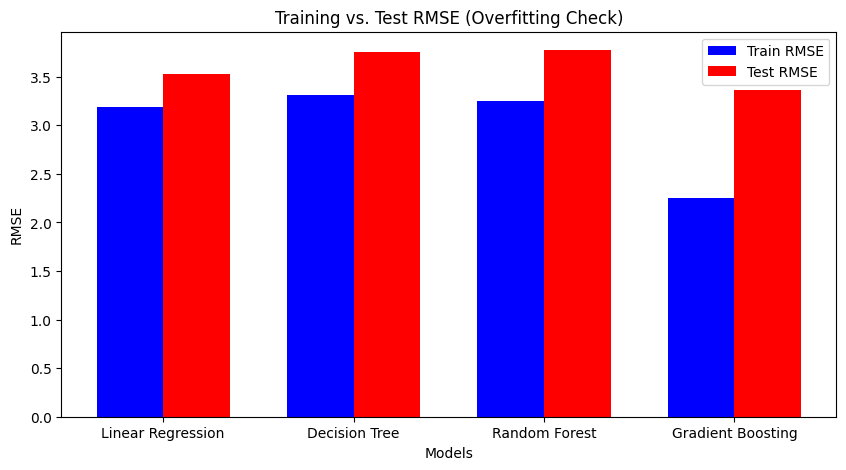

In [ ]:
# Evaluate models on training data to check for overfitting
lr_train_rmse = evaluator_rmse.evaluate(lr_model.transform(train_df))
dtr_train_rmse = evaluator_rmse.evaluate(dtr_model.transform(train_df))
rfr_train_rmse = evaluator_rmse.evaluate(rfr_model.transform(train_df))
gbt_train_rmse = evaluator_rmse.evaluate(gbt_model.transform(train_df))

# Print RMSE results for training and test sets
print(f"Linear Regression RMSE - Train: {lr_train_rmse}, Test: {lr_rmse}")
print(f"Decision Tree RMSE - Train: {dtr_train_rmse}, Test: {dtr_rmse}")
print(f"Random Forest RMSE - Train: {rfr_train_rmse}, Test: {rfr_rmse}")
print(f"Gradient Boosting RMSE - Train: {gbt_train_rmse}, Test: {gbt_rmse}")

# Plot RMSE for Training vs. Test
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
rmse_train_values = [lr_train_rmse, dtr_train_rmse, rfr_train_rmse, gbt_train_rmse]
rmse_test_values = [lr_rmse, dtr_rmse, rfr_rmse, gbt_rmse]

x = np.arange(len(models))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, rmse_train_values, width, label='Train RMSE', color='blue')
bars2 = ax.bar(x + width/2, rmse_test_values, width, label='Test RMSE', color='red')

ax.set_xlabel("Models")
ax.set_ylabel("RMSE")
ax.set_title("Training vs. Test RMSE (Overfitting Check)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


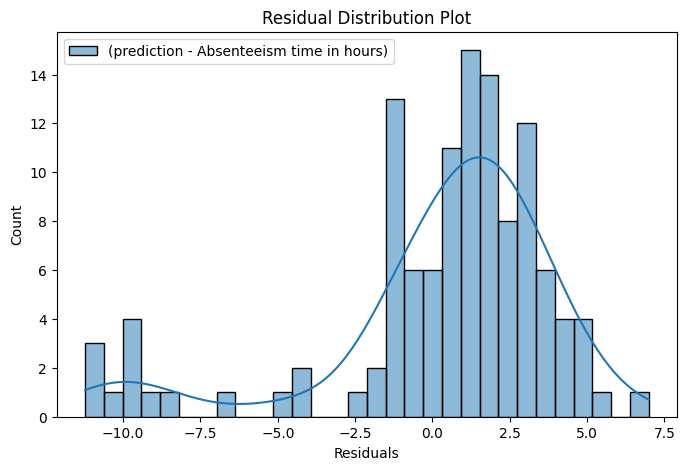

In [ ]:
import seaborn as sns

# Residuals for one model (Random Forest as an example)
residuals = rfr_predictions.select(col("prediction") - col(target_col)).toPandas()

# Plot Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Residual Distribution Plot")
plt.show()


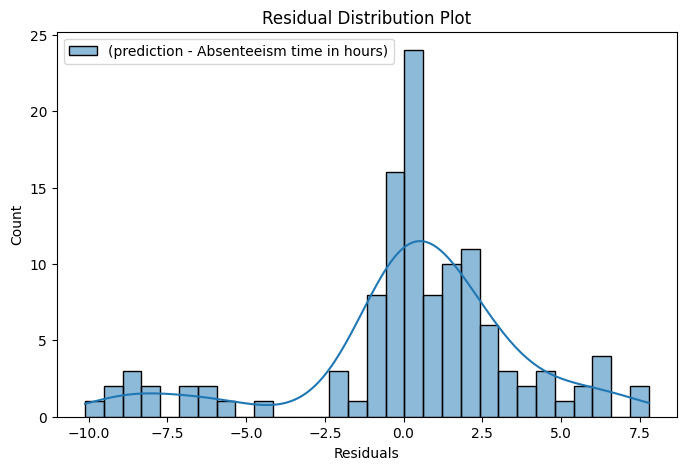

In [ ]:
# Residuals for one model (linear regression  as an example)
residuals = lr_predictions.select(col("prediction") - col(target_col)).toPandas()

# Plot Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Residual Distribution Plot")
plt.show()


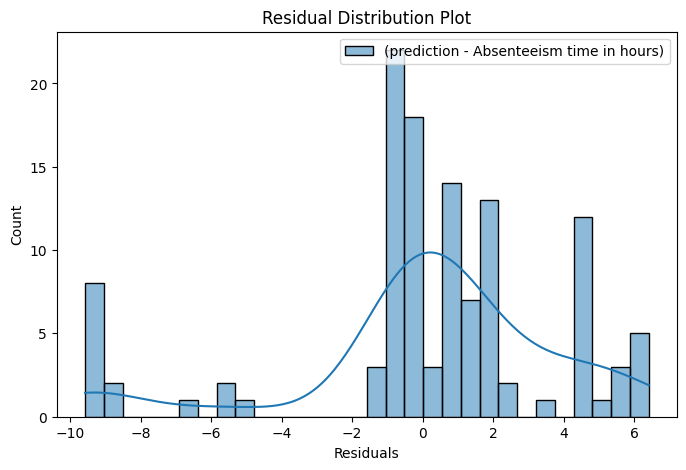

In [ ]:
# Residuals for one model (decision tree  as an example)
residuals = dtr_predictions.select(col("prediction") - col(target_col)).toPandas()

# Plot Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Residual Distribution Plot")
plt.show()


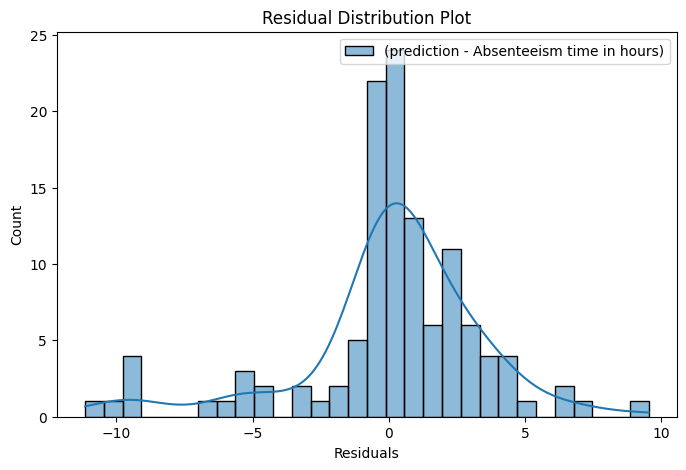

In [ ]:
# Residuals for one model (gradient boasting  as an example)
residuals = gbt_predictions.select(col("prediction") - col(target_col)).toPandas()

# Plot Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Residual Distribution Plot")
plt.show()


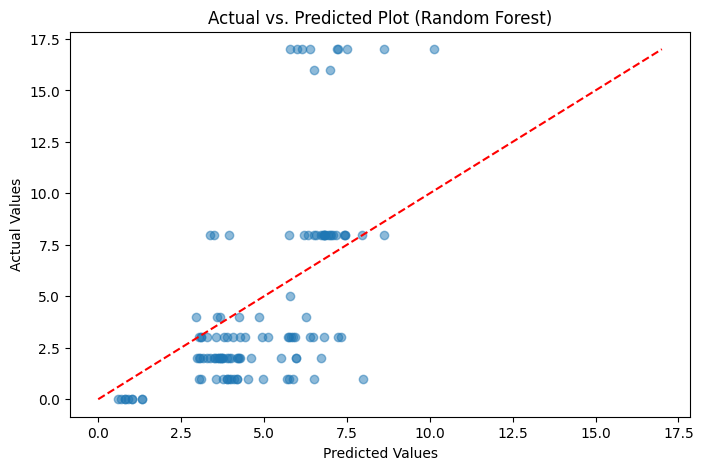

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(rfr_predictions.select("prediction").toPandas(),
            rfr_predictions.select(target_col).toPandas(), alpha=0.5)
plt.plot([min(rfr_predictions.select(target_col).toPandas().values),
          max(rfr_predictions.select(target_col).toPandas().values)],
         [min(rfr_predictions.select(target_col).toPandas().values),
          max(rfr_predictions.select(target_col).toPandas().values)], color='red', linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Actual vs. Predicted Plot (Random Forest)")
plt.show()


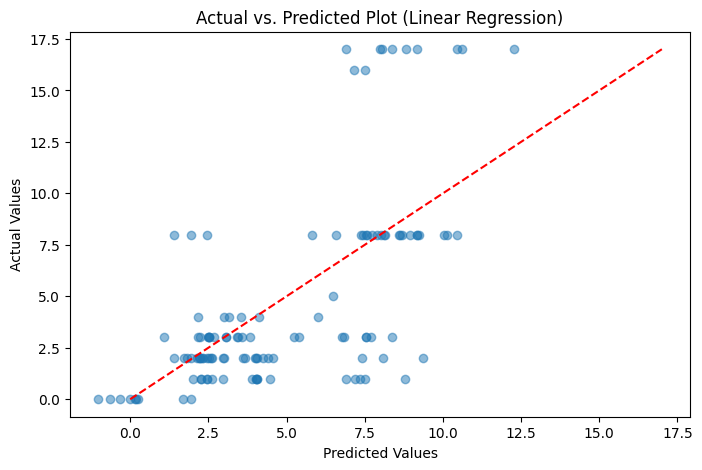

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(lr_predictions.select("prediction").toPandas(),
            lr_predictions.select(target_col).toPandas(), alpha=0.5)
plt.plot([min(lr_predictions.select(target_col).toPandas().values),
          max(lr_predictions.select(target_col).toPandas().values)],
         [min(lr_predictions.select(target_col).toPandas().values),
          max(lr_predictions.select(target_col).toPandas().values)], color='red', linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Actual vs. Predicted Plot (Linear Regression)")
plt.show()

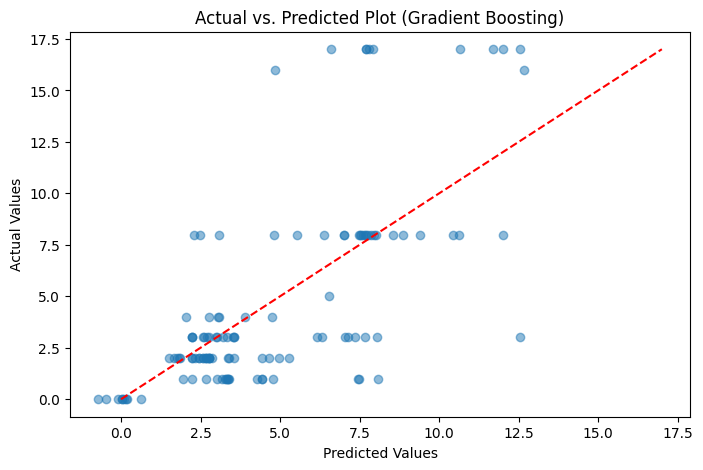

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(gbt_predictions.select("prediction").toPandas(),
            gbt_predictions.select(target_col).toPandas(), alpha=0.5)
plt.plot([min(gbt_predictions.select(target_col).toPandas().values),
          max(gbt_predictions.select(target_col).toPandas().values)],
         [min(gbt_predictions.select(target_col).toPandas().values),
          max(gbt_predictions.select(target_col).toPandas().values)], color='red', linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Actual vs. Predicted Plot (Gradient Boosting)")
plt.show()

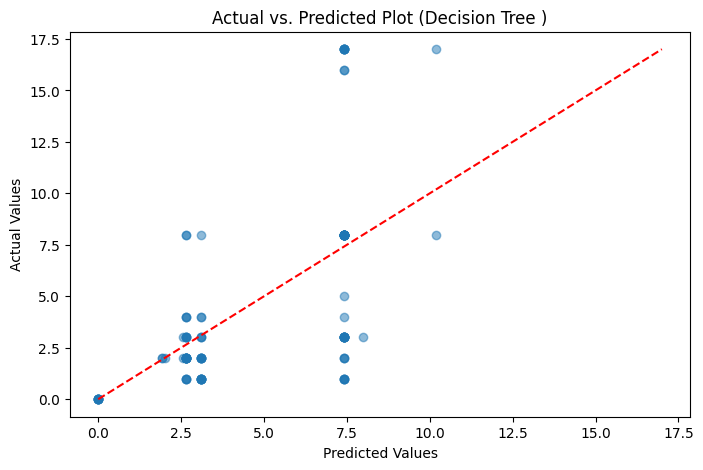

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(dtr_predictions.select("prediction").toPandas(),
            dtr_predictions.select(target_col).toPandas(), alpha=0.5)
plt.plot([min(dtr_predictions.select(target_col).toPandas().values),
          max(dtr_predictions.select(target_col).toPandas().values)],
         [min(dtr_predictions.select(target_col).toPandas().values),
          max(dtr_predictions.select(target_col).toPandas().values)], color='red', linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Actual vs. Predicted Plot (Decision Tree )")
plt.show()